<a href="https://colab.research.google.com/github/balajisriraj/Analytics-Vidhya-Customer-Segmentation/blob/master/Twitter_Trend_Finder_In_Progress_V0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Flow:

- Connect to Twittter API using the required creds
- Find the Top trending Hashtags
- Then filter the hashtags which are in English language
- Filter Top 3 Hashtags from that
- For these 3 hashtags, fetch 100 Tweets individually
- Combain all the 100 tweets into one big corpus
- Do basic Data Cleaning & Processing for better Tokenization
- Using Text to Text transformer t5 model Summarize the tweets
- Show Summarized text output for each Hashtag

In [345]:
#Installing the required packages 
!pip install googletrans 
! pip install transformers

     |████████████████████████████████| 1.1MB 2.7MB/s 
     |████████████████████████████████| 1.1MB 13.7MB/s 
     |████████████████████████████████| 3.0MB 17.4MB/s 
     |████████████████████████████████| 890kB 34.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=8afa79e45f2c002676c0fb74b2ea84253bb3db64388730aa8c4f24cb4f8df5d3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Import Python Modules

In [458]:
import pandas as pd
import tweepy
from tweepy import OAuthHandler
from tweepy import API
from googletrans import Translator
import datetime
import copy
import string
import re
import preprocessor as p
import matplotlib as mpl
import matplotlib.pyplot as plt
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
import torch
import json 
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
import os
import textwrap

In [459]:
#Basic Settings
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY,p.OPT.MENTION)
model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
device = torch.device('cuda')

In [460]:
#Past the keys extracted from teh Twitter App

In [461]:
# Consumer key authentication(consumer_key,consumer_secret can be collected from our twitter developer profile)
auth = OAuthHandler(consumer_key, consumer_secret)
# Access key authentication(access_token,access_token_secret can be collected from our twitter developer profile)
auth.set_access_token(access_token, access_token_secret)
# Set up the API with the authentication handler
api = API(auth)

In [462]:
WOE_ID = 2459115 # Where on Earth id can be extracted from https://nations24.com/world-wide
lan_find = Translator() # for finding teh language of the hashtags

In [463]:

def get_location_trends(locations, auth,n_hashtags,lang = 'en'):
  '''
  This function extracts the top trends for the selected location
  
  Function parameters 
  
  locations :   ID for the lcoation, which can be extarcted from https://nations24.com/world-wide
  auth      :   Authentication for Twitter API
  n_hashtags:   Integer Value, that defines number of top trending hashtags we are looking at
  lang      :   Language we are looking at for the tweets, by default its english
  '''
  api = API(auth)
  trends = api.trends_place(locations)
  data = trends[0]
  trends_data = data['trends']
  global tred_data
  tred_data = []
  for info in trends_data:
    tred_data.append([info['name'],info['tweet_volume'],lan_find.detect(info['name']).lang ] )
  tred_data = pd.DataFrame(tred_data, columns = list(['Hashtag',
                                                    'Tweet_Volume', 'Language'])).sort_values(by = ['Tweet_Volume'],ascending = False)
  #select english language trends
  tred_data = tred_data[tred_data.Language == lang]
  #select top 3 trends
  tred_data = tred_data.nlargest(n_hashtags,columns=['Tweet_Volume'])
  return tred_data

In [464]:
df_trending = get_location_trends(WOE_ID,auth,3,'en')
df_trending # Shows Top three hashtags & its corresponding Volume of Tweets

,Hashtag,Tweet_Volume,Language
0,Covid,5792294.0,en
4,Walter Reed,670319.0,en
1,Mr. President,245881.0,en


In [480]:
hashtag_list = list(df_trending['Hashtag']) #Gets list of Top n hashtags
hashtag_list = list(['#philosophy']) #Uncomment this & input any hashtag if you would like to look at any particulr hashtag 

In [481]:
def extract_tweets_for_htags(no_of_tweets,hashtag_list):
  '''
  This function extracts teh tweets for the Hashtags
  Parameters:
  no_of_tweets  : Integer, number of tweets to extract keep it between 100 to 500 for faster execution
  hashtag_list  : List of top trending Hashtags
  '''
  dict_of_df = {} 
  for htag in hashtag_list:
    today = datetime.datetime.now().strftime("%Y-%m-%d")
    tweets = tweepy.Cursor(api.search,q=htag,lang="en",since=today).items(no_of_tweets) #Extracting tweets for the htag
    tweets= [tweet.text for tweet in tweets] # Saving the tweets as list
    
    
    key_name = 'df_htag_'+str(htag)
    dict_of_df[key_name] = copy.deepcopy(tweets)
  return dict_of_df

In [482]:
dict_of_df = extract_tweets_for_htags(500,hashtag_list) #Dictionary that has data for all top three hashtags
hashtag_df_list = dict_of_df.keys() #List contains individual the key names for accessing the data inside the dictionary

In [483]:
def remove_punct(text):
    '''
    Remove punctuation of the string, and returns the string

    Parameters:
    text = String Value
  
    ''' 
  
    clean_text = []
    for tweet in text:
      tweet = re.sub(r"http\S+", "", tweet)
      text  = "".join([char for char in tweet if char not in string.punctuation])
      text = ''.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)","",text))
      text = text.replace('RT','').strip()
      clean_text.append(text)
    return clean_text


def wrap(line):
    broken = textwrap.wrap(line, 50, break_long_words=False)
    return '\n'.join(broken)

In [484]:
def clean_tweet():
  '''
  Function that returns cleaned string
  '''
  processed_data_dict = {}
  for htag in hashtag_df_list:
    df = dict_of_df[htag]
    df = remove_punct(df)
    key_name = str(htag)
    processed_data_dict[key_name] = copy.deepcopy(df)
  
  return processed_data_dict 

In [485]:
clean_data = clean_tweet()
df_clean_data = pd.DataFrame.from_dict(clean_data) # Dataframe taht contains string data for each hasgtag represented in each column
htags = df_clean_data.columns # Dataframe's Column list to iterate through data for each hashtag

In [488]:
def show_me_summary(htags,df):
  for htag in htags:
    temp =  df[htag].str.cat(sep=', ') # Select a column insert i here
    
    #Word Cloud
    print(f'Word Clod for the trending hashtag: {htag} \n') 
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color='white',stopwords=stopwords,max_words=200,max_font_size=40, random_state=42).generate(str(temp))
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show() # Shows teh Word Cloud for the Hashtag
    
    #Text Summary Model
    preprocess_text = temp.strip().replace("\n","") # Preprocessing the data
    t5_prepared_Text = "summarize: "+preprocess_text
    # print ("Original text preprocessed: \n", preprocess_text) # Uncomment this to see the Original Text
    tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt",  truncation=True)
    # Converting teh Tokens into ids for the Model
    summary_ids = model.generate(tokenized_text,do_sample=False,min_length=50 ,max_length=160, top_k=100, 
      top_p=0.95, num_return_sequences=4,num_beams=10,no_repeat_ngram_size=2,temperature=0.9,
      #early_stopping=True
       )
    
    output = tokenizer.decode(summary_ids[0], skip_special_tokens=True) # Decoding the Encoded ids into Words
    output = ('\n'.join(textwrap.wrap(output, 90, break_long_words=False)))
    
    output1 = tokenizer.decode(summary_ids[0], skip_special_tokens=True) # Decoding the Encoded ids into Words
    output1 = ('\n'.join(textwrap.wrap(output, 90, break_long_words=False)))
    
    output2 = tokenizer.decode(summary_ids[0], skip_special_tokens=True) # Decoding the Encoded ids into Words
    output2 = ('\n'.join(textwrap.wrap(output, 90, break_long_words=False)))
    
    output3 = tokenizer.decode(summary_ids[0], skip_special_tokens=True) # Decoding the Encoded ids into Words
    output3 = ('\n'.join(textwrap.wrap(output, 90, break_long_words=False)))
    
    
    
    print(f"\n\nSummarized text for {htag}: \n\n",output)
    print('*' *100)
    print('\n')


    print(f"\n\nSummarized text for {htag}: \n\n",output1)
    print('*' *100)
    print('\n')


    print(f"\n\nSummarized text for {htag}: \n\n",output2)
    print('*' *100)
    print('\n')


    print(f"\n\nSummarized text for {htag}: \n\n",output3)
    print('*' *100)
    print('\n')

Word Clod for the trending hashtag: df_htag_#philosophy 



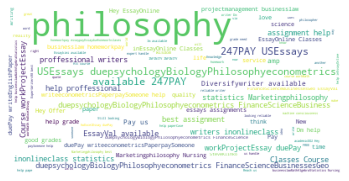



Summarized text for df_htag_#philosophy: 

 we learn again what Sartre meant by being free Psyche Ideas Philosophy, ExpertWriters98
Still looking out for a reliable writer Dm for help in businesslawMathAlgebraStatistics
Nursing.
****************************************************************************************************




Summarized text for df_htag_#philosophy: 

 we learn again what Sartre meant by being free Psyche Ideas Philosophy, ExpertWriters98
Still looking out for a reliable writer Dm for help in businesslawMathAlgebraStatistics
Nursing.
****************************************************************************************************




Summarized text for df_htag_#philosophy: 

 we learn again what Sartre meant by being free Psyche Ideas Philosophy, ExpertWriters98
Still looking out for a reliable writer Dm for help in businesslawMathAlgebraStatistics
Nursing.
****************************************************************************************************


In [489]:
show_me_summary(htags=htags, df =df_clean_data )